In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import shutil

In [ ]:
train_path = 'train/telephone'
test_path = 'test/telephone'

IMG_SIZE = (32,32)
BATCH_SIZE = 64
EPOCHS = 20
LATENT_DIM = 128
EMB_DIM = 64
COMMITMENT_COST = 0.25

a. [10 points] Construct and train a deep learning model as an image generator by using the images in your training dataset to train the model.

In [ ]:
def load_image_folder(folder, target_size=IMG_SIZE, max_images=None):
    folder = Path(folder)
    imgs = []
    for p in folder.rglob("*.png"):
        im = cv2.imread(str(p))
        if im is not None:
            im_resized = cv2.resize(im, target_size, interpolation=cv2.INTER_CUBIC)
            im_resized = im_resized.astype("float32") / 255.0
            imgs.append(im_resized)
            
            if max_images and len(imgs) >= max_images:
                break
    return np.stack(imgs, axis=0)

In [14]:
x_train = load_image_folder(train_path)
x_test = load_image_folder(test_path)

print("Train size:", len(x_train), "Test size:", len(x_test))

Train size: 500 Test size: 100


In [15]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(2048).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
def build_encoder(input_shape=(32,32,3), latent_dim=EMB_DIM):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(128, 4, strides=2, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(256, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(latent_dim, 1, padding="same", activation=None)(x)
    return keras.Model(inputs, x, name="encoder")

In [ ]:
def build_decoder(output_shape=(32,32,3), latent_dim=EMB_DIM):
    latent_inputs = keras.Input(shape=(8,8,latent_dim))
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(latent_inputs)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(3, 1, padding="same", activation="sigmoid")(x)
    return keras.Model(latent_inputs, x, name="decoder")

In [ ]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, **kwargs):
        super().__init__(**kwargs)
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        initializer = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(initializer(shape=(self.num_embeddings, self.embedding_dim)), trainable=True, name="embeddings")

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        flat = tf.reshape(inputs, [-1, self.embedding_dim])

        distances = (tf.reduce_sum(flat**2, axis=1, keepdims=True)
                     - 2 * tf.matmul(flat, self.embeddings, transpose_b=True)
                     + tf.reduce_sum(self.embeddings**2, axis=1))
        encoding_indices = tf.argmax(-distances, axis=1)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings)
        quantized = tf.reshape(quantized, input_shape)

        e_latent_loss = tf.reduce_mean((tf.stop_gradient(quantized) - inputs)**2)
        q_latent_loss = tf.reduce_mean((quantized - tf.stop_gradient(inputs))**2)
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        self.add_loss(loss)
        quantized = inputs + tf.stop_gradient(quantized - inputs)
        avg_probs = tf.reduce_mean(encodings, axis=0)
        return quantized, encoding_indices, avg_probs

In [ ]:
class VQVAE(keras.Model):
    def __init__(self, encoder, decoder, vq_layer, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.vq_layer = vq_layer

    def call(self, x):
        z_e = self.encoder(x)
        z_q, encoding_indices, avg_probs = self.vq_layer(z_e)
        x_recon = self.decoder(z_q)
        return x_recon

In [20]:
encoder = build_encoder()
decoder = build_decoder()
vq_layer = VectorQuantizer(LATENT_DIM, EMB_DIM, COMMITMENT_COST)
train_ds = train_ds.map(lambda x: (x, x))
test_ds = test_ds.map(lambda x: (x, x))

model = VQVAE(encoder, decoder, vq_layer)
model.compile(optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'], loss="mse")

history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds, verbose=2)


Epoch 1/20


8/8 - 5s - loss: 0.2377 - accuracy: 0.4182 - val_loss: 0.7673 - val_accuracy: 0.2617 - 5s/epoch - 669ms/step
Epoch 2/20
8/8 - 3s - loss: 0.9865 - accuracy: 0.3227 - val_loss: 1.5769 - val_accuracy: 0.4207 - 3s/epoch - 356ms/step
Epoch 3/20
8/8 - 3s - loss: 1.5166 - accuracy: 0.3669 - val_loss: 2.4382 - val_accuracy: 0.2705 - 3s/epoch - 356ms/step
Epoch 4/20
8/8 - 3s - loss: 1.3258 - accuracy: 0.3818 - val_loss: 1.3934 - val_accuracy: 0.5225 - 3s/epoch - 412ms/step
Epoch 5/20
8/8 - 3s - loss: 1.0554 - accuracy: 0.3765 - val_loss: 1.1551 - val_accuracy: 0.4989 - 3s/epoch - 435ms/step
Epoch 6/20
8/8 - 4s - loss: 0.9489 - accuracy: 0.4096 - val_loss: 0.7851 - val_accuracy: 0.2588 - 4s/epoch - 446ms/step
Epoch 7/20
8/8 - 4s - loss: 0.6926 - accuracy: 0.3352 - val_loss: 0.4591 - val_accuracy: 0.4893 - 4s/epoch - 460ms/step
Epoch 8/20
8/8 - 3s - loss: 0.3242 - accuracy: 0.4673 - val_loss: 0.1958 - val_accuracy: 0.4098 - 3s/epoch - 437ms/step
Epoch 9/20
8/8 - 3s - loss: 0.1493 - a

b. [5 points] Plot the training and validation losses over epochs, analyze, and explain what 
happened in the generative training based on the plot. 

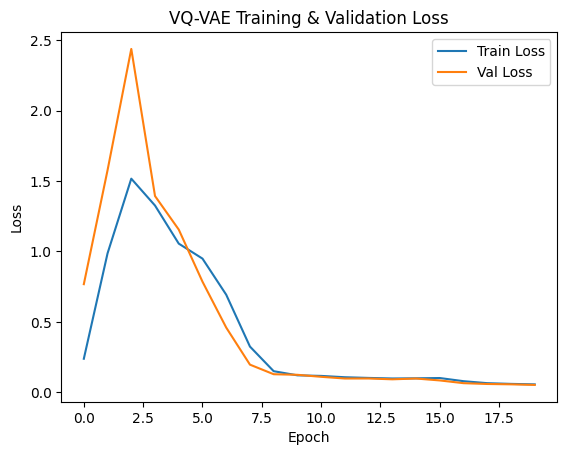

In [21]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("VQ-VAE Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

c. [10 points] Generate 500 images by using the trained model from point a. 

In [ ]:
os.makedirs('generate', exist_ok=True)
generated_z = np.random.randn(500, 8, 8, 64)
generated_images = decoder.predict(generated_z)
for i in range(generated_images.shape[0]):
    image_path = os.path.join('generate', f'generated_image_{i+1}.png')
    tf.keras.preprocessing.image.save_img(image_path, generated_images[i])

print("500 images have been saved in the 'generate' folder.")

16/16 [==============================] - 1s 50ms/step
500 images have been saved in the 'generate' folder.


d. [5 points] Compare 10 generated images and 10 original images, analyze and explain the comparison. 

1/1 [==============================] - 0s 157ms/step


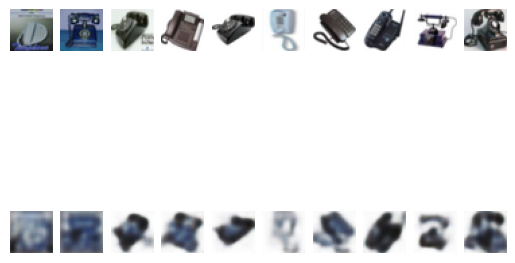

In [ ]:
batch = next(iter(test_ds))[0][:10]
reconstructed = model.predict(batch)

for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(batch[i])
    plt.axis("off")
    plt.subplot(2,10,i+11)
    plt.imshow(reconstructed[i])
    plt.axis("off")
plt.show()


e. [10 points] Construct a new dataset for classification with 2 classes: original and fake. Use your original training dataset as the original class and the generated images from point b as the fake class. 

In [ ]:
original_path = test_path
fake_path = "generate"

dataset_path = "dataset_classification"
real_dir = os.path.join(dataset_path, "real")
fake_dir = os.path.join(dataset_path, "fake")

os.makedirs(real_dir, exist_ok=True)
os.makedirs(fake_dir, exist_ok=True)

for f in os.listdir(original_path):
    shutil.copy(os.path.join(original_path, f), os.path.join(real_dir, f))

for f in os.listdir(fake_path): 
    shutil.copy(os.path.join(fake_path, f), os.path.join(fake_dir, f))

print("Dataset created successfully.")


Dataset created successfully.


In [37]:
classification_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

classification_ds = classification_ds.map(lambda x, y: (x / 255.0, y))

train_cls_size = int(len(classification_ds) * 0.8)
train_cls_ds = classification_ds.take(train_cls_size)
val_cls_ds = classification_ds.skip(train_cls_size)


Found 600 files belonging to 2 classes.


f. [10 points] Construct and train a deep learning model to classify original versus fake images by using the dataset from point d. 

In [ ]:
classifier = tf.keras.models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_cls = classifier.fit(
    train_cls_ds,
    validation_data=val_cls_ds,
    epochs=20,
    verbose=2
)


Epoch 1/20
8/8 - 2s - loss: 0.6578 - accuracy: 0.6914 - val_loss: 0.5975 - val_accuracy: 0.8295 - 2s/epoch - 259ms/step
Epoch 2/20
8/8 - 1s - loss: 0.5558 - accuracy: 0.8477 - val_loss: 0.5167 - val_accuracy: 0.8182 - 657ms/epoch - 82ms/step
Epoch 3/20
8/8 - 1s - loss: 0.5001 - accuracy: 0.8320 - val_loss: 0.5292 - val_accuracy: 0.7841 - 722ms/epoch - 90ms/step
Epoch 4/20
8/8 - 1s - loss: 0.4665 - accuracy: 0.8281 - val_loss: 0.5212 - val_accuracy: 0.7727 - 642ms/epoch - 80ms/step
Epoch 5/20
8/8 - 0s - loss: 0.4646 - accuracy: 0.8301 - val_loss: 0.4293 - val_accuracy: 0.8295 - 434ms/epoch - 54ms/step
Epoch 6/20
8/8 - 0s - loss: 0.4338 - accuracy: 0.8301 - val_loss: 0.4184 - val_accuracy: 0.8182 - 428ms/epoch - 54ms/step
Epoch 7/20
8/8 - 0s - loss: 0.4253 - accuracy: 0.8301 - val_loss: 0.4714 - val_accuracy: 0.7727 - 408ms/epoch - 51ms/step
Epoch 8/20
8/8 - 0s - loss: 0.4084 - accuracy: 0.8242 - val_loss: 0.4247 - val_accuracy: 0.8068 - 478ms/epoch - 60ms/step
Epoch 9/20
8/8 - 0s - loss

g. [5 points] Plot the training and validation losses over epochs, analyze, and explain what happened in the classification training based on the plot. 

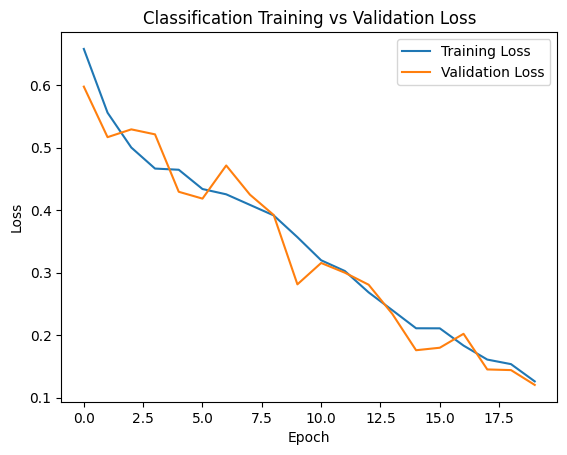

In [ ]:
plt.plot(history_cls.history['loss'], label="Training Loss")
plt.plot(history_cls.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Classification Training vs Validation Loss")
plt.legend()
plt.show()


h. [10 points] Do hyperparameter tuning to improve the deep learning model based on the result of point b and any other results you get from the training process. 

In [ ]:
LR = 0.0005
DROPOUT = 0.35
L2_REG = 0.001

tuned_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(DROPOUT),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(DROPOUT),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(DROPOUT),

    tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

optimizer = tf.keras.optimizers.AdamW(learning_rate=LR, weight_decay=1e-4)

tuned_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=6, restore_best_weights=True
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6
)

history_tuned = tuned_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, lr_schedule]
)

tuned_model.summary()


Epoch 1/20
8/8 [==============================] - 4s 160ms/step - loss: 0.8152 - accuracy: 0.2519 - val_loss: 0.8038 - val_accuracy: 0.2010 - lr: 5.0000e-04
Epoch 2/20
8/8 [==============================] - 1s 81ms/step - loss: 0.7791 - accuracy: 0.2337 - val_loss: 0.7823 - val_accuracy: 0.2600 - lr: 5.0000e-04
Epoch 3/20
8/8 [==============================] - 1s 73ms/step - loss: 0.7302 - accuracy: 0.2829 - val_loss: 0.7596 - val_accuracy: 0.3601 - lr: 5.0000e-04
Epoch 4/20
8/8 [==============================] - 1s 73ms/step - loss: 0.6949 - accuracy: 0.3530 - val_loss: 0.7486 - val_accuracy: 0.3153 - lr: 5.0000e-04
Epoch 5/20
8/8 [==============================] - 0s 56ms/step - loss: 0.6636 - accuracy: 0.3335 - val_loss: 0.7371 - val_accuracy: 0.2915 - lr: 5.0000e-04
Epoch 6/20
8/8 [==============================] - 0s 56ms/step - loss: 0.6456 - accuracy: 0.3446 - val_loss: 0.7309 - val_accuracy: 0.2899 - lr: 5.0000e-04
Epoch 7/20
8/8 [==============================] - 0s 56ms/step 

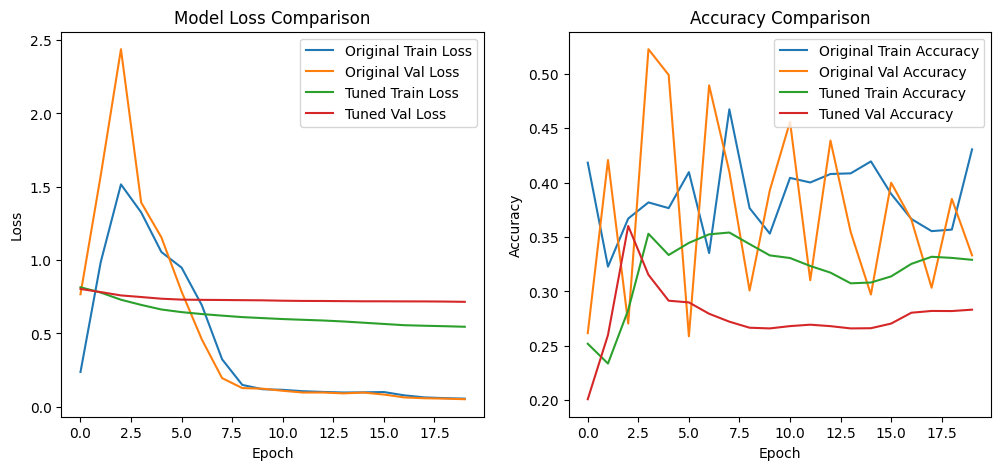

In [ ]:
orig_loss = history.history['loss']
orig_val_loss = history.history['val_loss']

tuned_loss = history_tuned.history['loss']
tuned_val_loss = history_tuned.history['val_loss']

orig_acc = history.history['accuracy']
orig_val_acc = history.history['val_accuracy']

tuned_acc = history_tuned.history['accuracy']
tuned_val_acc = history_tuned.history['val_accuracy']


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(orig_loss, label='Original Train Loss')
plt.plot(orig_val_loss, label='Original Val Loss')
plt.plot(tuned_loss, label='Tuned Train Loss')
plt.plot(tuned_val_loss, label='Tuned Val Loss')
plt.title("Model Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(orig_acc, label='Original Train Accuracy')
plt.plot(orig_val_acc, label='Original Val Accuracy')
plt.plot(tuned_acc, label='Tuned Train Accuracy')
plt.plot(tuned_val_acc, label='Tuned Val Accuracy')
plt.title("Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


i. [5 points] Test the classification model on a separate test set with appropriate metrics.

In [40]:
test_cls_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode='binary',    
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
).map(lambda x, y: (x / 255.0, y))


Found 600 files belonging to 2 classes.


In [41]:
test_cls_loss, test_cls_acc = classifier.evaluate(test_cls_ds)
print(f"Test Loss: {test_cls_loss}, Test Accuracy: {test_cls_acc}")


10/10 [==============================] - 0s 25ms/step - loss: 0.1119 - accuracy: 0.9717
Test Loss: 0.11193336546421051, Test Accuracy: 0.971666693687439


In [ ]:
y_true = []
y_pred = []

for images, labels in test_cls_ds:
    preds = classifier.predict(images)
    y_pred.extend((preds > 0.5).astype(int).flatten())
    y_true.extend(labels.numpy().flatten())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

1/1 [==============================] - 0s 142ms/step

Classification Report:
              precision    recall  f1-score   support

        Real       0.97      1.00      0.98       500
        Fake       1.00      0.83      0.91       100

    accuracy                           0.97       600
   macro avg       0.98      0.92      0.95       600
weighted avg       0.97      0.97      0.97       600


Confusion Matrix:
[[500   0]
 [ 17  83]]
